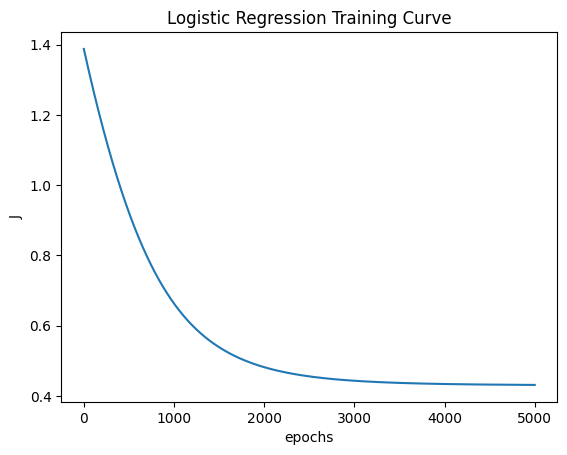

Logistic Regression Train Accuracy: 0.80975
Logistic Regression Test Accuracy: 0.817


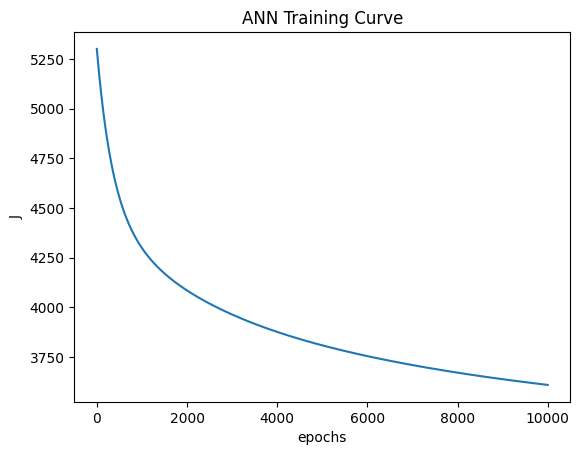

ANN Train Accuracy: 0.804625
ANN Test Accuracy: 0.8045


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


data = pd.read_csv("/content/Churn_Modelling - Churn_Modelling.csv")

y = data["Exited"].to_numpy()


feature_cols = [
    "CreditScore", "Geography", "Gender", "Age", "Tenure",
    "Balance", "NumOfProducts", "HasCrCard", "IsActiveMember",
    "EstimatedSalary"
]

df_X = data[feature_cols].copy()

df_X = pd.get_dummies(df_X, columns=["Geography", "Gender"], drop_first=True)

X = df_X.to_numpy().astype(float)


N = len(X)
shuffle_idx = np.random.permutation(N)

train_size = int(0.8 * N)
train_idx = shuffle_idx[:train_size]
test_idx  = shuffle_idx[train_size:]

X_train = X[train_idx]
X_test  = X[test_idx]

y_train = y[train_idx]
y_test  = y[test_idx]


mean = X_train.mean(axis=0)
std  = X_train.std(axis=0) + 1e-8

X_train = (X_train - mean) / std
X_test  = (X_test  - mean) / std


def sigmoid(h):
    return 1/(1+np.exp(-h))

def cross_entropy(y, p_hat):
    eps = 1e-12
    p_hat = np.clip(p_hat, eps, 1 - eps)
    return -(1/len(y))*np.sum(y*np.log(p_hat) + (1-y)*np.log(1-p_hat))

def accuracy(y, y_hat):
    return np.mean(y == y_hat)


class LogisticRegression:
    def __init__(self, thresh=0.5):
        self.thresh = thresh
        self.W = None
        self.b = None

    def fit(self, X, y, eta=2e-3, epochs=1e3, show_curve=True):
        epochs = int(epochs)
        N, D = X.shape

        self.W = np.random.randn(D)
        self.b = np.random.randn(1)

        J = np.zeros(epochs)

        for epoch in range(epochs):
            p_hat = self.__forward__(X)
            J[epoch] = cross_entropy(y, p_hat)

            self.W -= eta*(1/N)*X.T@(p_hat - y)
            self.b -= eta*(1/N)*np.sum(p_hat - y)

        if show_curve:
            plt.figure()
            plt.plot(J)
            plt.xlabel("epochs")
            plt.ylabel("J")
            plt.title("Logistic Regression Training Curve")
            plt.show()

    def __forward__(self, X):
        return sigmoid(X @ self.W + self.b)

    def predict(self, X):
        return (self.__forward__(X) >= self.thresh).astype(int)



log_reg = LogisticRegression()
log_reg.fit(X_train, y_train, eta=5e-3, epochs=5000)

y_train_hat = log_reg.predict(X_train)
y_test_hat  = log_reg.predict(X_test)

print("Logistic Regression Train Accuracy:", accuracy(y_train, y_train_hat))
print("Logistic Regression Test Accuracy:", accuracy(y_test, y_test_hat))



def one_hot_encode(y):
    N = len(y)
    K = len(set(y))
    Y = np.zeros((N, K))
    for i in range(N):
        Y[i, y[i]] = 1
    return Y

def softmax(H):
    H = H - np.max(H, axis=1, keepdims=True)
    eH = np.exp(H)
    return eH / eH.sum(axis=1, keepdims=True)

def cross_entropy_multi(Y, P_hat):
    eps = 1e-12
    P_hat = np.clip(P_hat, eps, 1 - eps)
    return -np.sum(Y * np.log(P_hat))

def ReLU(H):
    return H * (H > 0)

def dReLU(H):
    return (H > 0).astype(float)


class Shallow_ANN:
    def fit(self, X, y, neurons=32, eta=4e-4, epochs=10000, show_curve=True):
        epochs = int(epochs)
        N, D = X.shape
        Y = one_hot_encode(y)
        K = Y.shape[1]

        scale = 0.25
        self.W = {
            1: scale * np.random.randn(D, neurons),
            2: scale * np.random.randn(neurons, K)
        }
        self.B = {
            1: np.random.randn(neurons),
            2: np.random.randn(K)
        }

        self.a = {1: ReLU, 2: softmax}

        J = np.zeros(epochs)

        for epoch in range(epochs):
            self.__forward__(X)
            J[epoch] = cross_entropy_multi(Y, self.Z[2])

            # LAYER 2 UPDATE
            dZ2 = (self.Z[2] - Y)
            self.W[2] -= eta * (1/N) * self.Z[1].T @ dZ2
            self.B[2] -= eta * (1/N) * dZ2.sum(axis=0)

            # LAYER 1 UPDATE (correct ReLU derivative)
            dZ1 = (dZ2 @ self.W[2].T) * dReLU(self.Z[1])
            self.W[1] -= eta * (1/N) * X.T @ dZ1
            self.B[1] -= eta * (1/N) * dZ1.sum(axis=0)

        if show_curve:
            plt.figure()
            plt.plot(J)
            plt.xlabel("epochs")
            plt.ylabel("J")
            plt.title("ANN Training Curve")
            plt.show()

    def __forward__(self, X):
        self.Z = {0: X}
        self.Z[1] = self.a[1](self.Z[0] @ self.W[1] + self.B[1])
        self.Z[2] = self.a[2](self.Z[1] @ self.W[2] + self.B[2])

    def predict(self, X):
        self.__forward__(X)
        return self.Z[2].argmax(axis=1)



ann = Shallow_ANN()
ann.fit(X_train, y_train)

y_train_hat_ann = ann.predict(X_train)
y_test_hat_ann  = ann.predict(X_test)

print("ANN Train Accuracy:", accuracy(y_train, y_train_hat_ann))
print("ANN Test Accuracy:", accuracy(y_test, y_test_hat_ann))
